# DATA 608 Assignment 2

## Purpose: 
To visit techniques for dealing with big data, in particular binning and the datashader library.

## Dataset:
We explore the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

## Approach:
1. Import essential libraries and functions
2. Load and prepare our dataset
3. Define helper functions
4. Explore binning via Part 1 (Q1)
5. Explore datashader via Part 2 (Q2)


In [25]:
#Import essential libraries and functions
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

In [26]:
#Load in subset of PLUTO data to account for memory/ dtype errors
ny = pd.read_csv('pluto_20v8.csv', usecols=['borough','yearbuilt','numfloors','xcoord','ycoord','longitude','latitude','bbl','assesstot','assessland'])

#Account for missing values and set columns to desired data type
ny = ny.fillna(0) 

convert_dict = {'borough': str, 
                'numfloors': int,
                'yearbuilt': int,
                'xcoord': int,
                'ycoord': int
               } 
  
ny = ny.astype(convert_dict) 

# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]


In [27]:
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

# Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and 2D histograms. While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. 



## Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)


In [28]:
#The plot below exposes the imperfect data that we'll have to deal with:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': '32920197-45e9-4eac-8aa0-0ce186e7e73e',
 …

In [29]:
#Filter for columns of interest
##Use copy() to deal with SettingWithCopyWarning
ny_10s = ny[['yearbuilt','numfloors','bbl']].copy()

#Round DOWN yearbuilt entries to the nearest decade [ie. 1961 --> 1960]:
##Truncate the last digit, convert to int and then multiply by 10
ny_10s['decade'] = (np.floor(ny_10s ['yearbuilt'] / 10.0).astype(int) * 10)

trace = go.Bar(
    x = ny_10s.groupby('decade').count()['bbl'].index,
    y = ny_10s.groupby('decade').count()['bbl']
)
layout = go.Layout(
    xaxis = dict(title = 'Decade'),
    yaxis = dict(title = 'Lots Built')
)
fig = go.Figure(data = [trace], layout = layout)
py.iplot(fig)


Up until 1900 it appears there wasn't much building construction. It's my feeling this is more due to "poor documentation standards" or files being lost than construction all of sudden up-ticking in the 1900s. 

It's also interesting to observe the construction boom from the 1920s into the 1930s. Was there a major influx of immigration during this time? Was it due to the Roaring Twenties? Maybe companies and individuals had more expendable income (to build with) as a benefit of industrialization and the sudden emergence of the US as a major economic player.

...

From the 'yearbuilt obstacle', we turn our gaze toward binning building construction by number of floors. Because we were able to make a clearer breakdown of when construction occured, we'll continue our consideration of 

In [30]:
#We review summary statistics to familiarize ourselves with the range of values, etc.
ny_10s[["numfloors"]].describe()

#Familiarize selves with breakdown of count per stories built:
bins = [x for x in range(0,120) if (x % 10 == 0)] 
ny_10s['floor range'] = pd.cut(ny_10s.numfloors, bins)
ny_10s['floor range'].value_counts()

#'(' not included, ']' included

(0, 10]       804825
(10, 20]        4192
(20, 30]         855
(30, 40]         432
(40, 50]         203
(50, 60]          74
(60, 70]          24
(70, 80]          13
(80, 90]           6
(100, 110]         2
(90, 100]          0
Name: floor range, dtype: int64

The majority of our construction is concentrated from 1-10 floors, which makes sense. 

We can provide a logarithmic scale to better interpret these different floor ranges and keep all of our data on one plot OR we can provide two graphs: one for 1-10 floor construction and the other for 11+ floor construction broken into subgroups. Because construction is so overwhelmingly concentrated at 1-10 floors, I'll explore the 2nd option:

In [31]:
#Function to categorize / bin numfloors:
def floor_label(x):
    y = 0
    if x == 0: y = '1-10'
    elif x == 1: y = '11-20'
    elif x == 2: y = '21-30'
    elif x == 3: y = '31-40'
    elif x == 4: y = '41-50'
    else: y = '51+'
    return y

##Bin numfloors per every 10 floors: 1-10, 11-20, 21-30, 31-40, 41-50, 51+
ny_10s['fl_cat'] = (np.floor(ny_10s['numfloors'] / 10.0).astype(int) * 10)

#<= 10 stories filtering:
ny_10s_0 = ny_10s[(ny_10s['fl_cat'] == 0)]

trace = go.Bar(
    x = ny_10s_0.groupby('decade').count()['bbl'].index,
    y = ny_10s_0.groupby('decade').count()['bbl']
)
layout = go.Layout(
    xaxis = dict(title = 'Decade'),
    yaxis = dict(title = 'Lots Built'),
)
fig = go.Figure(data = [trace], layout = layout)
fig.update_layout(title = 'Lots Built per Decade of 1-10 Stories')
py.iplot(fig)


From the plot above, we get the extent to which 1-10 story lots were built from 1850 to 2020. Being that we discussed the '1900 point' earlier, we'll just highlight the boom of construction in the Roaring 20's, the dramatic drop from the 30's into the 40's a second peak in the 1950's (after WWII), and a third (minor) peak from the 90's into the 2000's that may mirror the rise in quality of life in NYC, followed by a fall after the Housing Market Crash of 2007.

It's nice to have explored this data separately because, now it frees up our second plot to explore the extent to which taller (11+ story) lots were built through the same range of decades:

In [32]:
# > 10 stories filtering:
#ny_10s['fl_cat'].value_counts()

ny_10s_10 = ny_10s[(ny_10s['fl_cat'] == 10)]
ny_10s_20 = ny_10s[(ny_10s['fl_cat'] == 20)]
ny_10s_30 = ny_10s[(ny_10s['fl_cat'] == 30)]
ny_10s_40 = ny_10s[(ny_10s['fl_cat'] == 40)]
ny_10s_50 = ny_10s[(ny_10s['fl_cat'] == 50)]


fig = go.Figure(data=[
    go.Bar(name='11-20', x = ny_10s_10.groupby('decade').count()['bbl'].index,
    y = ny_10s_10.groupby('decade').count()['bbl']),
    go.Bar(name='21-30', x = ny_10s_20.groupby('decade').count()['bbl'].index,
    y = ny_10s_20.groupby('decade').count()['bbl']),
    go.Bar(name='31-40', x = ny_10s_30.groupby('decade').count()['bbl'].index,
    y = ny_10s_30.groupby('decade').count()['bbl']),
    go.Bar(name='41-50', x = ny_10s_40.groupby('decade').count()['bbl'].index,
    y = ny_10s_40.groupby('decade').count()['bbl']),
    go.Bar(name='51+', x = ny_10s_50.groupby('decade').count()['bbl'].index,
    y = ny_10s_50.groupby('decade').count()['bbl'])
])

# Change the bar mode
fig.update_layout(barmode='stack', title = 'Lots Built per Decade of 11+ Stories', xaxis=dict(title='Decade'), yaxis = dict(title='Lots Built'))
fig.show()


The majority of lots built sit in the 11-20 story range, followed by 21-30, etc. as expected, but there are a number of interesting points worth highlighting while looking at this plot:
* the climb in height of buildings from 1910 to 1920 appears to signal technological advancement, greater construction capabilities, and the growth in demand for city living,
* a significant number of 41-50 story buildings were constructed in the 1930s. This is especially worth highlighting if we're to look into abnormally tall buildings from earlier decades,
* building construction, similar to the prior plot, dropped from the 20s through the 30s and into the 40s as the US entered the Great Depression and WWII,
* primarily led by 11-30 story buildings, construction had a second peak in the 1960s,
* 31-40 story buildings had relatively significant construction in the 60s, 80s, 2000s, and 2010, and
* in general, the amount of 51+ story buildings climbed steadily from the 60s through 2010.

While binning in the manner highlighted above provides significant insight into the amount and height of buildings constructed from 1850 to 2020, it might have been improved by narrowing our range to 1900-2020 and subtracting 1-20 story building construction (since it didn't address the question at hand.


# Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [12]:
#Provided code produced TypeError

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook Plotting Perils.

Here is what the same plot would look like in datashader:

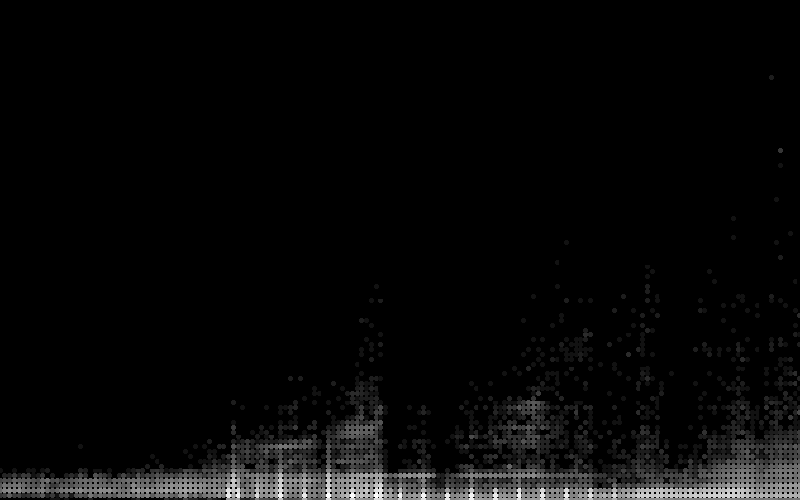

In [33]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

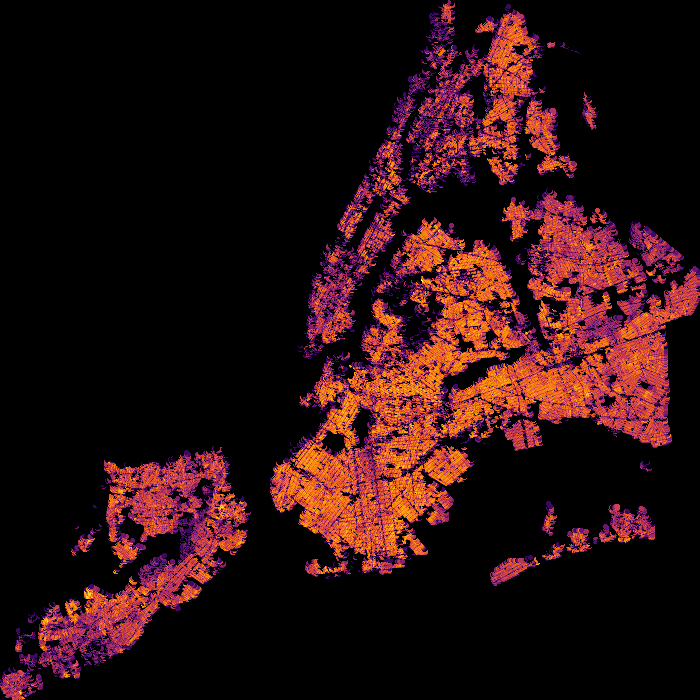

In [34]:
NewYorkCity   = ((913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their github repo. I would focus on the visualization pipeline and the US Census Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

## Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the Pluto data dictionary, you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about bivariate choropleth maps, and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

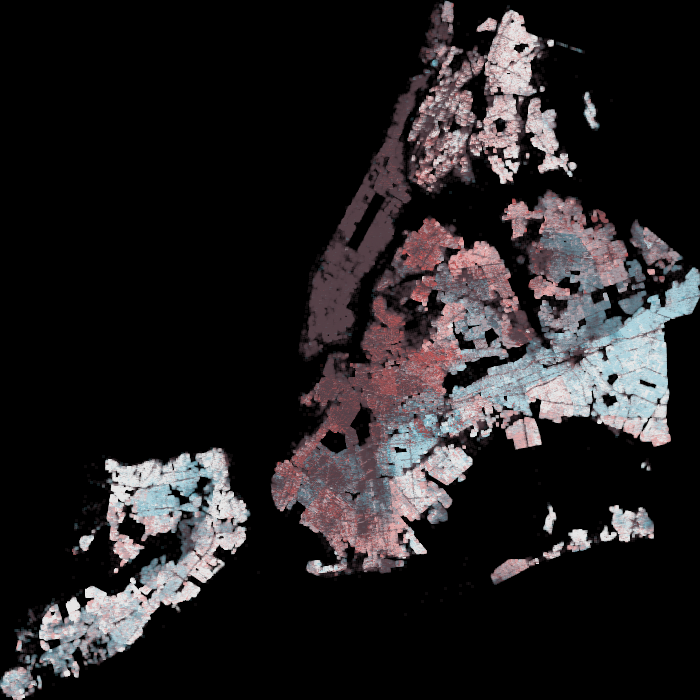

In [37]:
#BIN AND LABEL bivariate set for choropeth map

#Filter for columns of interest and create col: assessbldg = assesstot - assessland
ny_vals = ny[['xcoord','ycoord','assesstot','assessland']].copy() ##copy() deals with SettingWithCopyWarning
ny_vals['assessbldg'] = ny_vals['assesstot'].sub(ny_vals['assessland'], axis=0)

#Calculate breakpoints: split into thirds: 0 - 33.3,33.3 - 66.6, 66.6 - 100
##print(np.percentile(ny_vals[['assessland', 'assessbldg']], [33.3, 66.6], axis=0)) #[[11580. 29220.][18120. 55560.]]

#Bin and label land and building assessment based on breakpoints, right = False to deal with NaNs
ny_vals['v1'] = pd.cut(ny_vals['assessland'], [0, 11580, 18120, np.inf], right = False, labels=['A', 'B', 'C'])
ny_vals['v2'] = pd.cut(ny_vals['assessbldg'], [0, 29220, 55560, np.inf], right = False, labels=['1', '2', '3'])

ny_vals['bi_class'] = pd.Categorical(ny_vals['v1'].astype(str) + ny_vals['v2'].astype(str))
#ny_vals.groupby(['bi_class']).size() #confirm categories and counts


#VISUALIZE

#Specify color scheme
color_scheme = ['#e8e8e8','#e4acac','#c85a5a', #C1, C2, C3
                '#b0d5df','#ad9ea5','#985356', #B1, B2, B3
                '#64acbe','#627f8c','#574249'] #A1, A2, A3

#Setup canvas
NewYorkCity   = ((913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)

#Populate canvas
agg = cvs.points(ny_vals, 'xcoord', 'ycoord', ds.count_cat('bi_class'))
view = tf.shade(agg, color_key=color_scheme)
export(tf.spread(view, px=1), 'choropleth')


## Analysis

Based on our selected color scheme:
* the gray-brown hue represents the meeting place of high value land and buildings, 
* the red hue represents higher value land with lower value buildings (underbuilt), 
* the blue hue represents higher value buildings on lower value land (overbuilt), and 
* the white hue represents the meeting place of lower value land and buildings.

From these findings we may seek development from Western Queens toward the South-west of Brooklyn.


Part 1 References:
* https://www.listendata.com/2019/07/how-to-filter-pandas-dataframe.html (filtering)
* https://stackoverflow.com/questions/26454649/python-round-up-to-the-nearest-ten/26454777 (rounding decades, I elected floor() rather than ceil))
* https://www.youtube.com/watch?v=GGL6U0k8WYA (plotly)
* https://plotly.com/python/bar-charts/ (stacked bar charts)

Part 2 References:
* https://anaconda.org/jbednar/pipeline/notebook (datashader visualization pipeline)
* https://github.com/holoviz/datashader/tree/master/examples (datashader examples)
* https://anaconda.org/jbednar/census/notebook (US census example)
* https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/ (bivariate chloropeth maps)